# Example `Dysmalpy` 1D fitting #

**Includes the following components:**
 - Disk + Bulge
 - NFW halo
 - Constant velocity dispersion

#### First import modules ####

In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

from dysmalpy import galaxy
from dysmalpy import models
from dysmalpy import fitting
from dysmalpy import instrument
from dysmalpy import data_classes
from dysmalpy import parameters
from dysmalpy import plotting
from dysmalpy import aperture_classes

import os
import copy

import numpy as np
import astropy.units as u
import astropy.io.fits as fits

##### Setup notebook #####

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import Image

In [3]:
import logging
logger = logging.getLogger('DysmalPy')
logger.setLevel(logging.INFO)

#### Set data, output paths ####

In [4]:
# Data directory
data_dir = '/Users/sedona/data/dysmalpy_example_data/'
#'/YOUR/DATA/PATH/'

# Where to save output files
#outdir  = './output_1D/'
outdir = '/Users/sedona/data/dysmalpy_test_examples/JUPYTER_OUTPUT_1D/'

-------------------

##### Set function to tie scale height relative to effective radius #####

In [5]:
def tie_sigz_reff(model_set):
 
    reff = model_set.components['disk+bulge'].r_eff_disk.value
    invq = model_set.components['disk+bulge'].invq_disk
    sigz = 2.0*reff/invq/2.35482

    return sigz

----------

## Initialize galaxy, model set, instrument ##

In [6]:
gal = galaxy.Galaxy(z=1.613, name='GS4_43501')
mod_set = models.ModelSet()
inst = instrument.Instrument()

### Baryonic component: Combined Disk+Bulge ###

In [7]:
total_mass = 11.0    # M_sun
bt = 0.3             # Bulge-Total ratio
r_eff_disk = 5.0     # kpc
n_disk = 1.0
invq_disk = 5.0
r_eff_bulge = 1.0    # kpc
n_bulge = 4.0
invq_bulge = 1.0
noord_flat = True    # Switch for applying Noordermeer flattening

# Fix components
bary_fixed = {'total_mass': False,
              'r_eff_disk': True,
              'n_disk': True,
              'r_eff_bulge': True,
              'n_bulge': True,
              'bt': True}

# Set bounds
bary_bounds = {'total_mass': (10, 13),
               'r_eff_disk': (1.0, 30.0),
               'n_disk': (1, 8),
               'r_eff_bulge': (1, 5),
               'n_bulge': (1, 8),
               'bt': (0, 1)}

bary = models.DiskBulge(total_mass=total_mass, bt=bt,
                        r_eff_disk=r_eff_disk, n_disk=n_disk,
                        invq_disk=invq_disk,
                        r_eff_bulge=r_eff_bulge, n_bulge=n_bulge,
                        invq_bulge=invq_bulge,
                        noord_flat=noord_flat,
                        name='disk+bulge',
                        fixed=bary_fixed, bounds=bary_bounds)

bary.r_eff_disk.prior = parameters.BoundedGaussianPrior(center=5.0, stddev=1.0)

### Halo component ###

In [8]:
mvirial = 12.0
conc = 5.0

halo_fixed = {'mvirial': False,
              'conc': True}

halo_bounds = {'mvirial': (10, 13),
               'conc': (1, 20)}

halo = models.NFW(mvirial=mvirial, conc=conc, z=gal.z,
                  fixed=halo_fixed, bounds=halo_bounds, name='halo')
halo.mvirial.prior = parameters.BoundedGaussianPrior(center=11.5, stddev=0.5)

### Dispersion profile ###

In [9]:
sigma0 = 39.   # km/s
disp_fixed = {'sigma0': False}
disp_bounds = {'sigma0': (10, 200)}

disp_prof = models.DispersionConst(sigma0=sigma0, fixed=disp_fixed,
                                          bounds=disp_bounds, name='dispprof')

### z-height profile ###

In [10]:
sigmaz = 0.9   # kpc
zheight_fixed = {'sigmaz': False}

zheight_prof = models.ZHeightGauss(sigmaz=sigmaz, name='zheightgaus',
                                   fixed=zheight_fixed)
zheight_prof.sigmaz.tied = tie_sigz_reff

### Geometry ###

In [11]:
inc = 62.     # degrees
pa = 142.     # degrees, blue-shifted side CCW from north
xshift = 0    # pixels from center
yshift = 0    # pixels from center

geom_fixed = {'inc': True,
              'pa': True,
              'xshift': True,
              'yshift': True}

geom_bounds = {'inc': (0, 90),
               'pa': (90, 180),
               'xshift': (0, 4),
               'yshift': (-10, -4)}

geom = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift,
                       fixed=geom_fixed, bounds=geom_bounds, name='geom')

## Add all model components to ModelSet ##

In [12]:
# Add all of the model components to the ModelSet
mod_set.add_component(bary, light=True)
mod_set.add_component(halo)
mod_set.add_component(disp_prof)
mod_set.add_component(zheight_prof)
mod_set.add_component(geom)

### Set kinematic options for calculating velocity profile ###

In [13]:
mod_set.kinematic_options.adiabatic_contract = False
mod_set.kinematic_options.pressure_support = True

### Set up the instrument ###

In [14]:
beamsize = 0.55*u.arcsec                 # FWHM of beam
sig_inst = 45*u.km/u.s                   # Instrumental spectral resolution

beam = instrument.GaussianBeam(major=beamsize)
lsf = instrument.LSF(sig_inst)

inst.beam = beam
inst.lsf = lsf
inst.pixscale = 0.125*u.arcsec           # arcsec/pixel
inst.fov = [33, 33]                      # (nx, ny) pixels
inst.spec_type = 'velocity'              # 'velocity' or 'wavelength'
inst.spec_step = 10*u.km/u.s             # Spectral step
inst.spec_start = -1000*u.km/u.s         # Starting value of spectrum
inst.nspec = 201                         # Number of spectral pixels

# Set the beam kernel so it doesn't have to be calculated every step
inst.set_beam_kernel()
inst.set_lsf_kernel()

## Add the model set, instrument to the Galaxy ##

In [15]:
gal.model = mod_set
gal.instrument = inst

## Load data ##

* Load the data from file:
  - *1D velocity, dispersion profiles and error*
  - *A mask can be loaded / created as well*
  
* Put data in `Data1D` class

* Add data to Galaxy object

In [16]:
dat_arr = np.loadtxt(data_dir+'GS4_43501.obs_prof.txt')
gs4_r = dat_arr[:,0]
gs4_vel = dat_arr[:,1]
gs4_disp = dat_arr[:,3]
err_vel = dat_arr[:,2]
err_disp = dat_arr[:,4]
inst_corr = True                  # Flag for if the measured dispersion has been
                                  # corrected for instrumental resolution
    
# Put data in Data1D data class: 
#    ** specifies slit width, slit PA as well **
data1d = data_classes.Data1D(r=gs4_r, velocity=gs4_vel,
                                  vel_disp=gs4_disp, vel_err=err_vel,
                                  vel_disp_err=err_disp, slit_width=beamsize.value,
                                  slit_pa=pa, inst_corr=inst_corr)

# Add data to Galaxy object:
gal.data = data1d


In [17]:
# Setup apertures: circular apertures placed on the cube for GS4_43501.

aperture_radius = 0.5 * gal.instrument.beam.major.value

profile1d_type = 'circ_ap_cube'
moment_calc  = False    # 1D data was extracted using Gaussian fits

gal.data.apertures = aperture_classes.setup_aperture_types(gal=gal, 
                profile1d_type=profile1d_type, 
                aperture_radius=aperture_radius, 
                from_data=True, 
                partial_weight=True,
                moment=moment_calc)

-----------------

# MPFIT Fitting #

## MPFIT fitting parameters: ##

In [18]:
# Options passed to MPFIT:
maxiter = 200

# Other options:
do_plotting = True       # Plot bestfit, corner, trace or not
oversample = 1           # Factor by which to oversample model (eg, subpixels)
fitdispersion = True     # Fit dispersion profile in addition to velocity

outdir_mpfit = outdir+'MPFIT/'

## Run `Dysmalpy` fitting: MPFIT ##

In [19]:
mpfit_results = fitting.fit_mpfit(gal, oversample=oversample,
                                        fitdispersion=fitdispersion,
                                        profile1d_type=gal.data.profile1d_type,
                                        maxiter=maxiter,
                                        do_plotting=do_plotting,
                                        outdir=outdir_mpfit,
                                        plot_type='png')

INFO:DysmalPy:Making path=/Users/sedona/data/dysmalpy_test_examples/JUPYTER_OUTPUT_1D/MPFIT/
INFO:DysmalPy:*************************************
INFO:DysmalPy: Fitting: GS4_43501 using MPFIT
INFO:DysmalPy:
mvirial_tied: False
INFO:DysmalPy:nSubpixels: 1
INFO:DysmalPy:
MPFIT Fitting:
Start: 2020-10-14 17:58:12.165263

INFO:DysmalPy:Iter 1  CHI-SQUARE = 149.2029675  DOF = 33
   disk+bulge:total_mass = 11  
   halo:mvirial = 12  
   dispprof:sigma0 = 39  

INFO:DysmalPy:Iter 2  CHI-SQUARE = 72.92756404  DOF = 33
   disk+bulge:total_mass = 10.85430537  
   halo:mvirial = 12.4056713  
   dispprof:sigma0 = 45.21064044  

INFO:DysmalPy:Iter 3  CHI-SQUARE = 66.01245199  DOF = 33
   disk+bulge:total_mass = 10.83408531  
   halo:mvirial = 12.33176996  
   dispprof:sigma0 = 44.6938513  

INFO:DysmalPy:Iter 4  CHI-SQUARE = 66.01133039  DOF = 33
   disk+bulge:total_mass = 10.83390907  
   halo:mvirial = 12.33033411  
   dispprof:sigma0 = 44.67360372  

INFO:DysmalPy:Iter 5  CHI-SQUARE = 66.01133038

## Examine MPFIT results ##

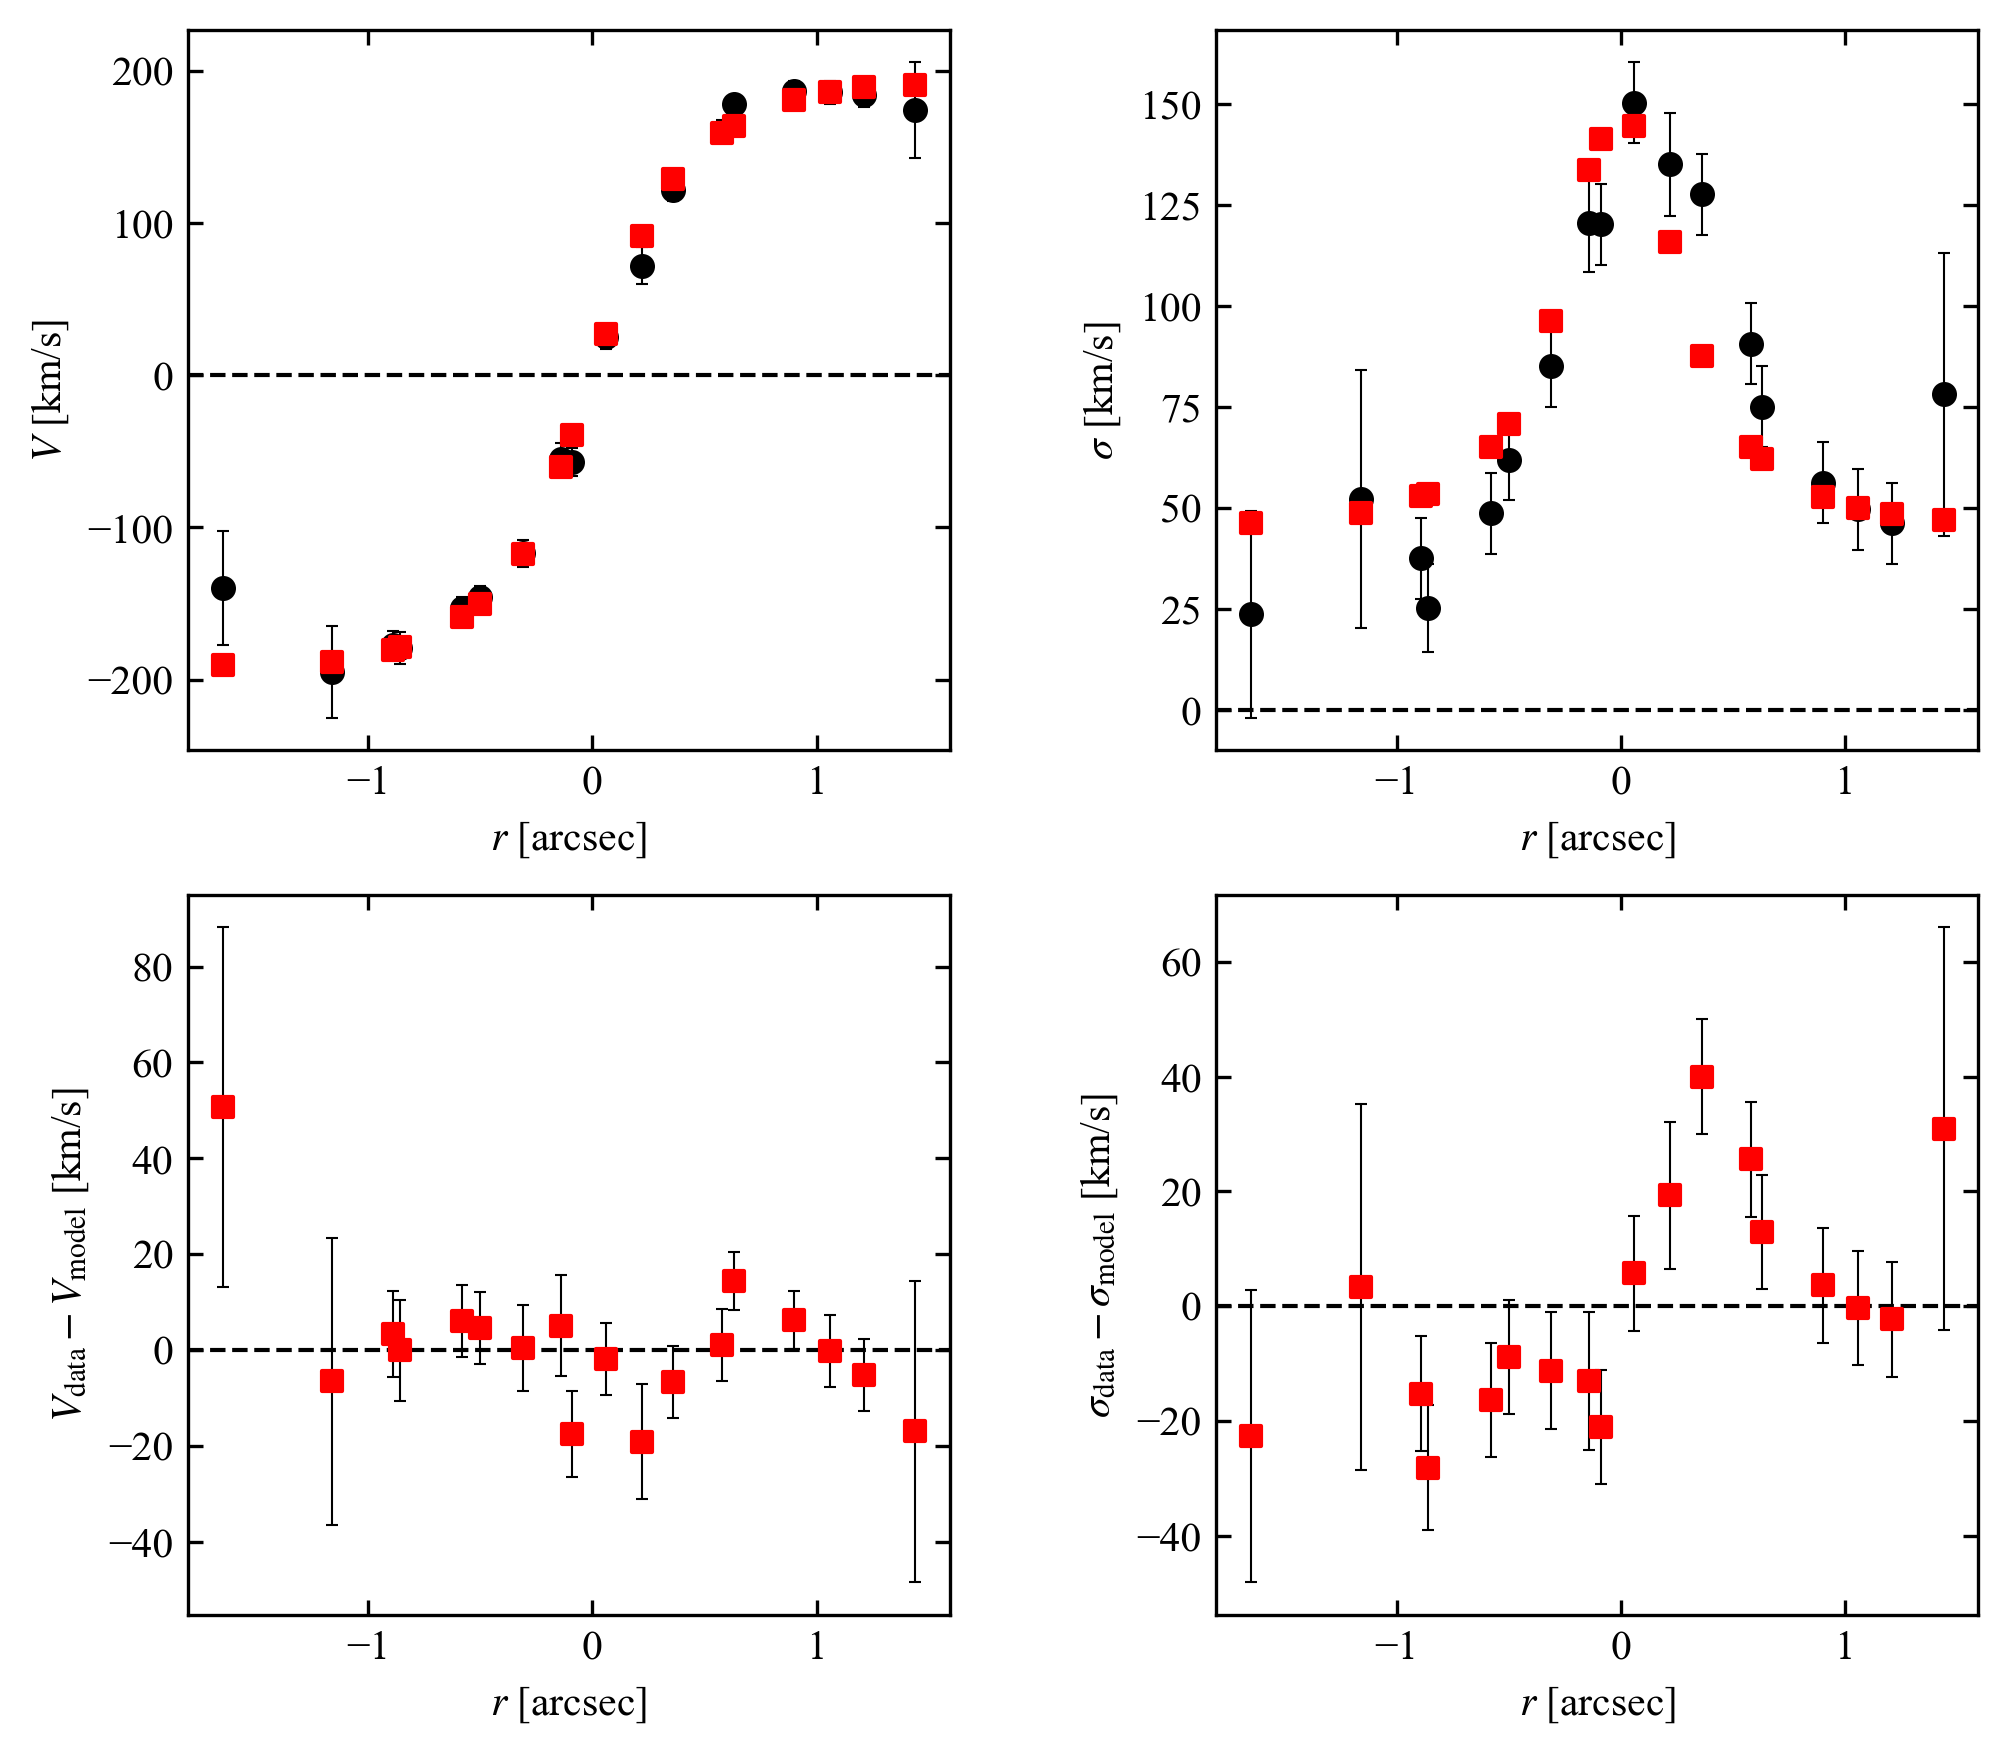

In [20]:
# Look at best-fit:
filepath = outdir_mpfit+"mpfit_best_fit.png"
Image(filename=filepath, width=600, height=570)

-----------------

# MCMC Fitting #

### MCMC fitting parameters ###

Set parameters for fitting: 
   - Passing options to `emcee`
   - Other calculation options

In [21]:
# Options passed to emcee
nwalkers = 500
ncpus = 4
scale_param_a = 2
nburn = 50
nsteps = 50
minaf = None
maxaf = None
neff = 10

# Other options
do_plotting = True       # Plot bestfit, corner, trace or not
oversample = 1           # Factor by which to oversample model (eg, subpixels)
fitdispersion = True     # Fit dispersion profile in addition to velocity

outdir_mcmc = outdir + 'MCMC/'

-------

## Run `Dysmalpy` fitting: MCMC ##

In [22]:
mcmc_results = fitting.fit(gal, nWalkers=nwalkers, nCPUs=ncpus,
                               scale_param_a=scale_param_a, nBurn=nburn,
                               nSteps=nsteps, minAF=minaf, maxAF=maxaf,
                               nEff=neff, do_plotting=do_plotting,
                               oversample=oversample, outdir=outdir_mcmc,
                               fitdispersion=fitdispersion,
                               profile1d_type=gal.data.profile1d_type,
                               plot_type='png')

INFO:DysmalPy:Making path=/Users/sedona/data/dysmalpy_test_examples/JUPYTER_OUTPUT_1D/MCMC/
INFO:DysmalPy:*************************************
INFO:DysmalPy: Fitting: GS4_43501 with MCMC
INFO:DysmalPy:
nCPUs: 4
INFO:DysmalPy:nWalkers: 500
INFO:DysmalPy:lnlike: red_chisq=False
INFO:DysmalPy:lnlike: oversampled_chisq=True
INFO:DysmalPy:
blobs: None
INFO:DysmalPy:
mvirial_tied: False
INFO:DysmalPy:nSubpixels: 1
INFO:DysmalPy:
Burn-in:
Start: 2020-10-14 17:59:23.960278

INFO:DysmalPy: k=0, time.time=2020-10-14 17:59:23.963776, a_frac=nan
INFO:DysmalPy: k=1, time.time=2020-10-14 18:02:17.730173, a_frac=0.36
INFO:DysmalPy: k=2, time.time=2020-10-14 18:03:22.409733, a_frac=0.359
INFO:DysmalPy: k=3, time.time=2020-10-14 18:04:20.734649, a_frac=0.36
INFO:DysmalPy: k=4, time.time=2020-10-14 18:05:37.977788, a_frac=0.365
INFO:DysmalPy: k=5, time.time=2020-10-14 18:06:53.245831, a_frac=0.3556
INFO:DysmalPy: k=6, time.time=2020-10-14 18:08:01.948383, a_frac=0.359
INFO:DysmalPy: k=7, time.time=2020

KeyboardInterrupt: 

## Examine MCMC results ##

In [19]:
# Look at trace:
filepath = outdir_mcmc+"mcmc_trace.png"
Image(filepath, width=600, height=400)

In [20]:
# Look at best-fit:
filepath = outdir_mcmc+"mcmc_best_fit.png"
Image(filepath, width=600, height=570)

In [21]:
# Look at corner:
filepath = outdir_mcmc+"mcmc_param_corner.png"
Image(filepath, width=570, height=620)

---------

## Reload data ##

Helpful for:
  - replotting
  - reanalyzing chain (eg, jointly constraining some posteriors)
  - ...

In [22]:
# For compatibility with Python 2.7:
mod_in = copy.deepcopy(gal.model)
gal.model = mod_in
    
# Initialize a basic dummy results class
mcmc_results = fitting.MCMCResults(model=gal.model)

# Set what the names are for reloading: using default names
fsampler = outdir_mcmc+'mcmc_sampler.pickle'
fresults = outdir_mcmc+'mcmc_results.pickle'

mcmc_results.reload_mcmc_results(filename=fresults)
mcmc_results.reload_sampler(filename=fsampler)

------

----------